# RLHF-Aesthetic Tuned (RAT) model for prompt synthesis

I finetuned, using RLHF (Reinforcement Learning from Human Feedback) by myself overnight like a goblin over Google Colab, a model for generating and extending Stable Diffusion prompts.

This (https://hf.co/crumb/bloom-560m-RLHF-SD2-prompter-aesthetic) is a further finetuned version of [crumb/bloom-560m-RLHF-SD2-prompter](https://hf.co/crumb/bloom-560m-RLHF-SD2-prompter) (that model) to optimize for aesthetic score with models from https://github.com/crowsonkb/simulacra-aesthetic-models instead of me hand scoring each image

by [crumb](https://twitter.com/aicrumb)

In [ ]:
#@markdown This cell installs the necessary libraries to run the models.
!pip install transformers diffusers accelerate -qq

     |████████████████████████████████| 5.8 MB 5.8 MB/s 
     |████████████████████████████████| 453 kB 48.7 MB/s 
     |████████████████████████████████| 191 kB 29.3 MB/s 
     |████████████████████████████████| 182 kB 27.0 MB/s 
     |████████████████████████████████| 7.6 MB 60.1 MB/s 


In [ ]:
#@markdown This cell imports the required libraries and loads Stable Diffusion.
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
from transformers import pipeline
from IPython.display import clear_output
import torch

model_id = "stabilityai/stable-diffusion-2" #@param ["stabilityai/stable-diffusion-2-base", "stabilityai/stable-diffusion-2"]

scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, revision="fp16", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

if model_id=="stability/stable-diffusion-2":
    pipe.enable_attention_slicing()

clear_output()

In [ ]:
#@markdown This cell loads textual-inversion embeddings from the Huggingface Hub. Make sure before you try to load one that it was made specifically for Stable Diffusion 2.
from huggingface_hub import HfApi
!pip install wget -q
import wget
import os
import requests
from huggingface_hub import hf_hub_download
api = HfApi()

def load_learned_embed_in_clip(learned_embeds_path, text_encoder, tokenizer, token=None):
        loaded_learned_embeds = torch.load(learned_embeds_path, map_location="cpu")
        
        # separate token and the embeds
        trained_token = list(loaded_learned_embeds.keys())[0]
        embeds = loaded_learned_embeds[trained_token]

        # cast to dtype of text_encoder
        dtype = text_encoder.get_input_embeddings().weight.dtype
        embeds.to(dtype)

        # add the token in tokenizer
        token = token if token is not None else trained_token
        num_added_tokens = tokenizer.add_tokens(token)
        i = 1

        # resize the token embeddings
        text_encoder.resize_token_embeddings(len(tokenizer))
        
        # get the id for the token and assign the embeds
        token_id = tokenizer.convert_tokens_to_ids(token)
        text_encoder.get_input_embeddings().weight.data[token_id] = embeds
        return token

textual_inversion_ids = ["minimaxir/wrong_embedding_sd_2_0"] #@param

models = []
for model in textual_inversion_ids:
    model_content = {}
    model_content["id"] = model
    embeds = (model, "learned_embeds.bin")
    embeds_file = hf_hub_download(embeds[0], embeds[1])
    
    token_identifier = (model, "token_identifier.txt")
    tokens_file = hf_hub_download(token_identifier[0], token_identifier[1])

    token_name = open(tokens_file, "r").read()
    print("adding", token_name)

    learned_token = load_learned_embed_in_clip(embeds_file, pipe.text_encoder, pipe.tokenizer, token_name)
    model_content["token"] = learned_token
    models.append(model_content)
clear_output()

In [ ]:
#@markdown This cell loads the transformer model that will be used to autocomplete the prompts.

prompt_tuner = "crumb/bloom-560m-RLHF-SD2-prompter-aesthetic" #@param ["crumb/bloom-560m-RLHF-SD2-prompter-aesthetic", "crumb/bloom-560m-RLHF-SD2-prompter"]
prompt_pipe = pipeline("text-generation", model=prompt_tuner)
clear_output()

In [ ]:
#@markdown Input / Augment your prompt! Run this as many times as you like to create a new extended prompt.
prompt = "cool cyberpunk landscape" #@param {type:"string"}

temperature = 0.7 #@param {type:"slider", min:0, max:1, step:0.05}
max_length = 42 #@param

prompt = "<s>Prompt: " + prompt + ","
extended_prompt = prompt_pipe(prompt, do_sample=True, max_length=max_length)[0]['generated_text']
extended_prompt = extended_prompt[10:].strip()
print("Your prompt extended is now: ", extended_prompt)

negative = "in the style of <wrong>, broken, amateur, poorly drawn, ugly, flat, boring, ugly" #@param {type:"string"}

Your prompt extended is now:  cool cyberpunk landscape, concept art, art station, featured on cgsociety, highly detailed, intricate, sharp


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

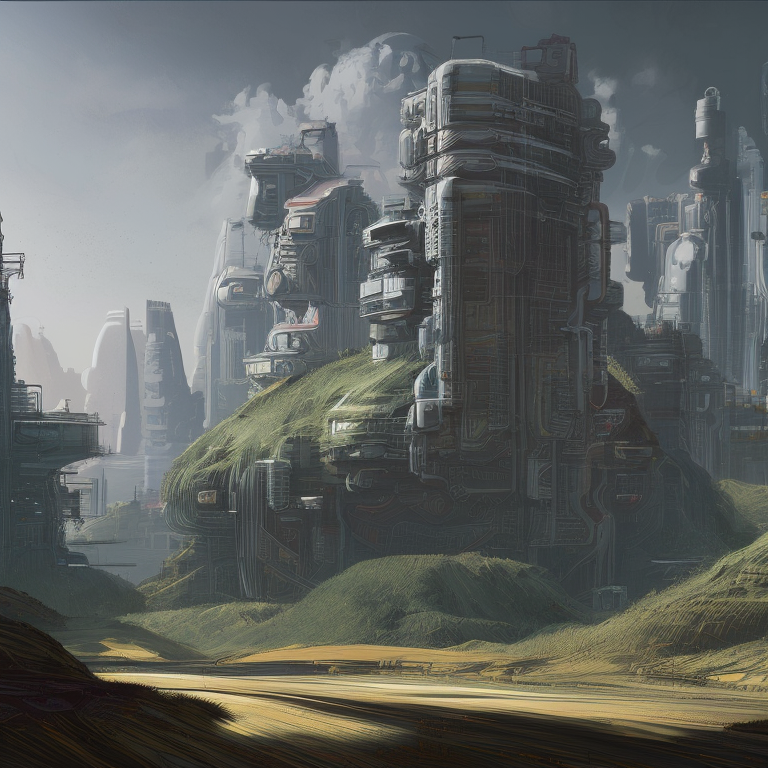

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
#@markdown Generate!
from IPython.display import display, Image
from tqdm.auto import trange

guidance_scale = 7.5 #@param
height = 768 #@param
width = 768 #@param
steps = 50 #@param
images = 4 #@param

for _ in trange(images):
    image = pipe(extended_prompt, negative_promt=negative, 
                 num_inference_steps=steps, 
                 height=height, width=width,
                 guidance_scale=guidance_scale).images[0]  
    image.save("output.png")
    display(Image("output.png"))